# Training an RNN for Time Series Predictions

We can use an RNN, just like a CNN, to make predictions on the MNIST dataset. The only difference being that we will input the image flattened and unrolled into the RNN; we will treat each 28 x 28 pixels image as 28 rows or 28 pixels each. 

### Add diagram of the network we intend to create

## Feature Engineering

### Loading the Data

In [1]:
%%bash 
ls -la crypto_data/

total 49752
drwxr-xr-x@  6 rajatrasal  staff      204 20 Nov 02:52 .
drwxr-xr-x  13 rajatrasal  staff      442 23 Nov 20:11 ..
-rwxr-xr-x@  1 rajatrasal  staff  5925778 27 Aug 11:23 BCH-USD.csv
-rwxr-xr-x@  1 rajatrasal  staff  6658291 25 Aug 12:42 BTC-USD.csv
-rwxr-xr-x@  1 rajatrasal  staff  6657679 25 Aug 12:42 ETH-USD.csv
-rwxr-xr-x@  1 rajatrasal  staff  6223190 25 Aug 12:42 LTC-USD.csv


From this we can see that all the data for each type of crypto-currency is in different files. We want to somehow put this together into one usable file for easy access.

In [2]:
import pandas as pd

col_names = ["time", "low", "high", "open", "close", "volume"]
df = pd.read_csv("./crypto_data/LTC-USD.csv", names=col_names)
df.head()

,time,low,high,open,close,volume
0,1528968660,96.580002,96.589996,96.589996,96.580002,9.647200
1,1528968720,96.449997,96.669998,96.589996,96.660004,314.387024
2,1528968780,96.470001,96.570000,96.570000,96.570000,77.129799
3,1528968840,96.449997,96.570000,96.570000,96.500000,7.216067
4,1528968900,96.279999,96.540001,96.500000,96.389999,524.539978


### Visualising Existing Data

Now we import all the data we want into one dataframe. This will make it easier to access later. We also change the column names style to make them easier to reference. 

In [3]:
from os import listdir

datapath = "./crypto_data/"
datafiles = listdir(datapath)

ratios = []

main_df = pd.DataFrame()

for file in datafiles:
    full_file = f"{datapath}{file}"
    ratio = file[:-4].lower().replace("-", "_")
    ratios.append(ratio)
    
    df = pd.read_csv(full_file, names=col_names)
    df.set_index("time", inplace=True)
    df = df[["close", "volume"]]
    df.rename(columns={"close": f"{ratio}_close", "volume": f"{ratio}_volume"}, inplace=True)
    print(f"{ratio} dataframe size:{df.shape}")
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df)
    
print(f"\nMain dataframe size:{main_df.shape}")
main_df.head()

bch_usd dataframe size:(92225, 2)
btc_usd dataframe size:(97724, 2)
eth_usd dataframe size:(102831, 2)
ltc_usd dataframe size:(101883, 2)

Main dataframe size:(92225, 8)


,bch_usd_close,bch_usd_volume,btc_usd_close,btc_usd_volume,eth_usd_close,eth_usd_volume,ltc_usd_close,ltc_usd_volume
time,,,,,,,,
1528968660,871.719971,5.675361,6489.549805,0.587100,NaN,NaN,96.580002,9.647200
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978


Text(0.5,1,'Time Series Graph for Cryptocurrencies')

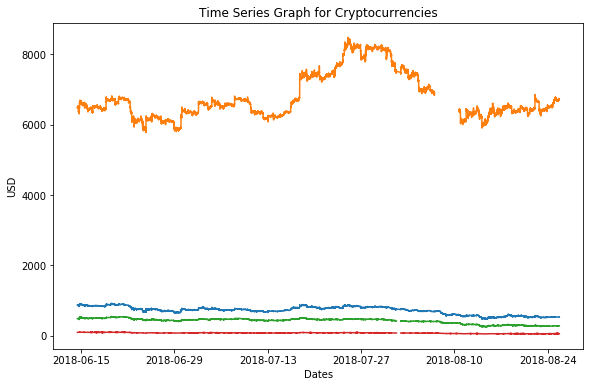

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [9.5, 6]
dates = main_df.index.map(lambda x : datetime.fromtimestamp(x))
closes = [col for col in main_df.columns.values if col[-5:] == "close"]
for df in [main_df[col] for col in closes]:
    plt.plot(dates, df)
plt.xlabel("Dates")
plt.ylabel("USD")
plt.title("Time Series Graph for Cryptocurrencies")

Text(0.5,1,'Time Series for Bitcoin Cash')

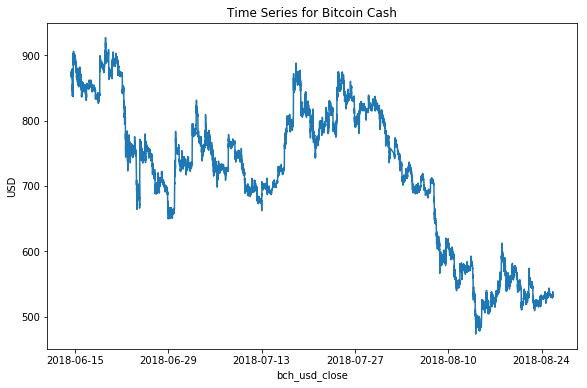

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.plot(dates, main_df.loc[:, "bch_usd_close"])
plt.xlabel("bch_usd_close")
plt.ylabel("USD")
plt.title("Time Series for Bitcoin Cash")

### Making Targets

Finally, we can take each close datapoint for each cryptocurrency and map it to the value it will have a few datapoints in the future. Thus creating a rudimental targets column.

In [6]:
import numpy as np

close_cols = [ratio for ratio in ratios]
ratio_to_predict = close_cols[0]
r = f"{ratio_to_predict}_future"
main_df[r] = main_df[f"{ratio_to_predict}_close"].shift(-3)
main_df.head()

,bch_usd_close,bch_usd_volume,btc_usd_close,btc_usd_volume,eth_usd_close,eth_usd_volume,ltc_usd_close,ltc_usd_volume,bch_usd_future
time,,,,,,,,,
1528968660,871.719971,5.675361,6489.549805,0.587100,NaN,NaN,96.580002,9.647200,870.789978
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024,870.000000
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799,869.989990
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067,869.450012
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978,869.989990


We are going to use a 1 or 0 to indicate whether the current is greater than the future or not. This is done using the `classify` function.

In [7]:
classify = lambda current, future : int(float(current) > float(future))

For our initial set of predicts, I want to only make predictions on bitcoin cash data, so we can filter out the appropriate columns from the main dataframe.

In [8]:
t = f"{ratio_to_predict}_target"
main_df[t] = list(map(classify, main_df[f"{ratio_to_predict}_close"], main_df[r]))
bch_df = main_df[[f"{ratio_to_predict}_close", r, t]]
bch_df.head(10)

,bch_usd_close,bch_usd_future,bch_usd_target
time,,,
1528968660,871.719971,870.789978,1
1528968720,870.859985,870.000000,1
1528968780,870.099976,869.989990,1
1528968840,870.789978,869.450012,1
1528968900,870.000000,869.989990,1
1528968960,869.989990,870.000000,0
1528969020,869.450012,870.320007,0
1528969080,869.989990,870.650024,0
1528969140,870.000000,871.219971,0


An out of sample testing set needs to be selected. This will be the final 5% of the data.

In [9]:
from datetime import datetime

times = sorted(bch_df.index.values)
last_5pc = times[-int(len(times) * 0.05):]

print(times[0] < last_5pc[0])
print(datetime.fromtimestamp(times[0]), datetime.fromtimestamp(last_5pc[0]))

True
2018-06-14 10:31:00 2018-08-21 20:32:00


In [10]:
bch_df = bch_df.loc[:, ['bch_usd_close', 'bch_usd_future']]
bch_df.head()

,bch_usd_close,bch_usd_future
time,,
1528968660,871.719971,870.789978
1528968720,870.859985,870.000000
1528968780,870.099976,869.989990
1528968840,870.789978,869.450012
1528968900,870.000000,869.989990


Based on the testing row indices, a training/test split can be made from the bitcoin cash dataframe.

In [11]:
train = bch_df.drop(last_5pc)
test = bch_df.loc[bch_df.index.isin(last_5pc), :]

print(train.shape)
print(test.shape)

(87614, 2)
(4611, 2)


We now need to split out training and test set into features (X) and labels (y).

In [12]:
from sklearn import preprocessing
from collections import deque
import random

SEQ_LEN = 20

def train_test_split(stocks_df):
    
    for col in stocks_df.columns: 
        if "target" not in col:
            # We want to normalise the data so that each close and volume 
            # values are within the same order or magnitude.
            stocks_df[col] = stocks_df[col].pct_change()
            stocks_df.dropna(inplace=True)
            stocks_df[col] = preprocessing.scale(stocks_df[col].values)
            
    stocks_df.dropna(inplace=True)
    
    sequential_data = []
    seq_len_chunk = deque(maxlen=SEQ_LEN)
    
    for i, row in enumerate(stocks_df.values):
        seq_len_chunk.append(row)
        if i != 0 and i % SEQ_LEN == 0:
            seq = np.array(seq_len_chunk)
            sequential_data.append([seq[:, :-1], np.array([seq[:, -1]])])
            
    random.shuffle(sequential_data)
    
    sequential_data = np.array(sequential_data)
    X = sequential_data[:, :-1]
    y = sequential_data[:, -1]
    
    return (X, y)

In [13]:
X_train, y_train = train_test_split(train)
X_test, y_test = train_test_split(test)
print(X_train.shape)
print(y_train.shape)

(4380, 1)
(4380,)


/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [14]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (4380, 1)
y_train: (4380,)


### Resizing training and testing data for Tensorflow model

In [15]:
reshape_x = lambda array : np.array([col for row in array for col in row])

def reshape_y(array, n_outputs):
    y_train = np.array([col for row in array for col in row])
    return y_train.reshape((y_train.shape[0], y_train.shape[1], n_outputs))

In [16]:
X_train = reshape_x(X_train)
y_train = reshape_y(y_train, len(y_train[0]))
print(X_train.shape)
print(y_train.shape)

(4380, 20, 1)
(4380, 20, 1)


## Creating the Model

In [17]:
import tensorflow as tf

/Users/rajatrasal/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Hyperparameters Initialisation

I initially plan on using the Nesterov Accelerated Gradient optimizer, so with that in mind will need to include values for the momentum and learning rate hyperparameters. 

In [18]:
learning_rate = 0.001

# Number of sequences we are feeding into the model as a single input,
# our RNN is going to unrolled over n_steps many times steps because
# this is how long each mini-batch will be.
n_steps = SEQ_LEN 

# Number of neurons in each cell. Each unrolled time step
n_neurons = 100

# Number of features in each inputs = number of recurrent neurons at each layer
n_inputs = X_train.shape[2]

# Number of output classes
n_outputs = y_train.shape[2]

### Construction

We are going to use an RNN to learn our model. By treating the type of recurrent neuron cell being used as a hyperparameter, we can test whether the losses converge faster with one type of neuron than another. 

In [19]:
import tensorflow as tf

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs], name='X')
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs], name='y')

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


### Execution

In [24]:
epochs = 150
batch_size = 50

train_size = len(X_train)

losses_val = []
losses_training = []

sess = tf.Session()
    
init.run(session=sess)

for epoch in range(epochs):
    print(epoch, end = " ")
    X_train, y_train = train_test_split(train)
    X_test, y_test = train_test_split(test)

    X_train = reshape_x(X_train)
    y_train = reshape_y(y_train, n_outputs)
    assert X_train.shape == y_train.shape

    X_test = reshape_x(X_test)
    y_test = reshape_y(y_test, n_outputs)
    assert X_test.shape == y_test.shape

    for i in range(0, len(X_train), batch_size):
        #print(i, end=" ")
        split_slice = slice(i, min(train_size, i+batch_size), 1)
        X_train_batch = X_train[split_slice]
        y_train_batch = y_train[split_slice]
        sess.run(training_op, feed_dict={X: X_train_batch, y: y_train_batch})

    loss_train = loss.eval(session=sess, feed_dict={X: X_train, y: y_train})
    loss_val = loss.eval(session=sess, feed_dict={X: X_test, y: y_test})
    losses_val.append(loss_val)
    losses_training.append(loss_train)
    # print()

0 

/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 

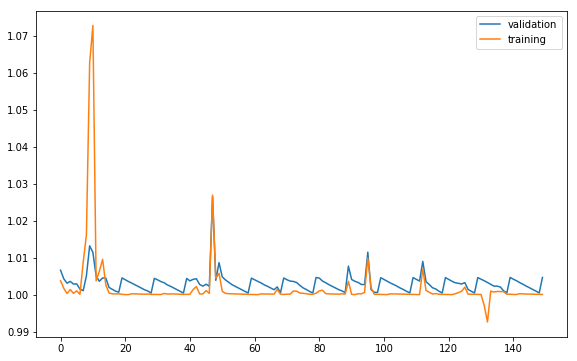

In [25]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.plot(losses_val, label="validation")
plt.plot(losses_training, label="training")
plt.legend()

## Hyperparameter Tuning

## Making Predictions

In [73]:
bch_df.shape

(92225, 2)

In [74]:
X_trial, y_expected = train_test_split(train[200:8000])
X_trial = reshape_x(X_trial)
y_expected = reshape_y(y_expected, n_outputs)

/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rajatrasal/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [75]:
X_trial.shape

(389, 20, 1)

In [76]:
X_trial = X_trial.astype(np.float32)

In [78]:
type(X_trial[0][0][0])

numpy.float32

In [77]:
y_pred = sess.run(outputs, feed_dict={X: X_trial})

TypeError: unhashable type: 'numpy.ndarray'